In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
last_date = session.query(func.max(measurement.date)).scalar()
last_date

'2017-08-23'

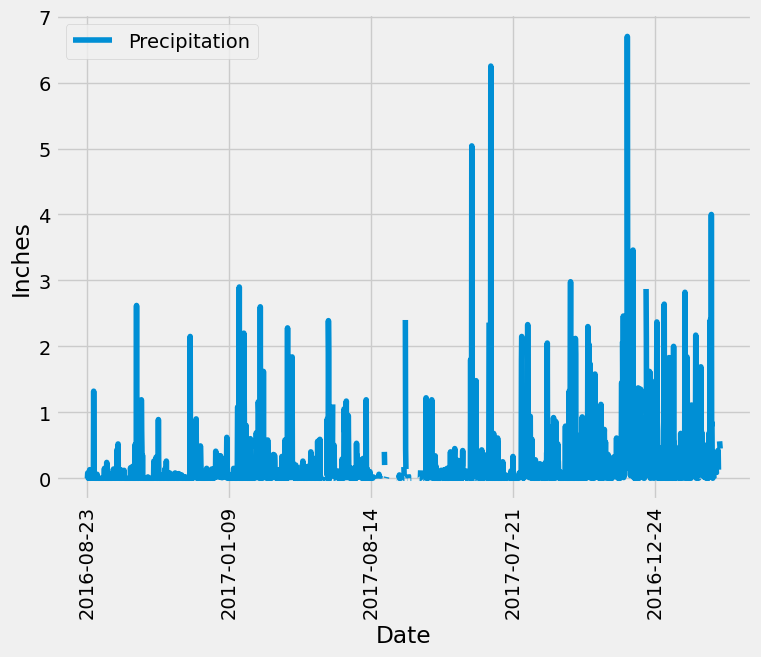

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year, month, day = map(int, last_date.split("-"))
last_year = dt.date(year,month,day) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_year_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
results_df = pd.DataFrame(last_year_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
sorted_df = results_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
results_df.plot(x = "Date", y = "Precipitation", rot=90, figsize=(8,6))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(func.count(station.station)).scalar()
stations

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0]

lowest_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == most_active_station_id).scalar()
highest_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == most_active_station_id).scalar()
avg_temp = round(session.query(func.avg(measurement.tobs)).filter(measurement.station == most_active_station_id).scalar(),1)

print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.7


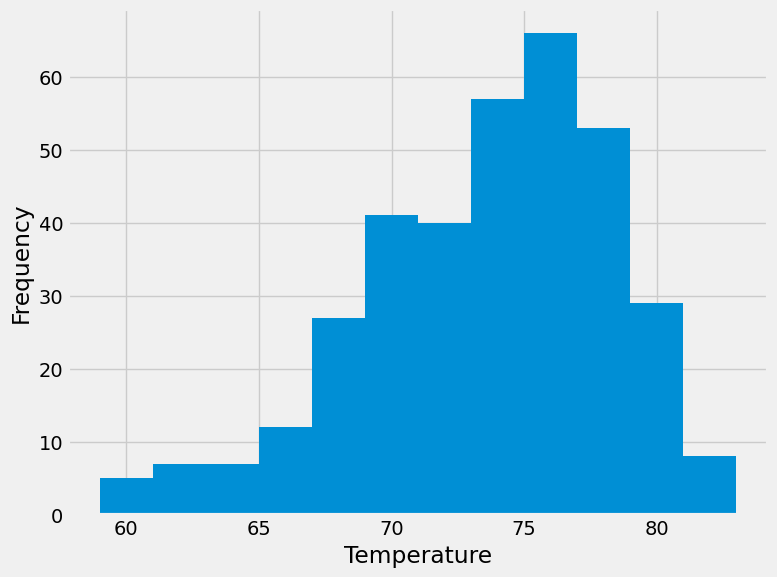

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(measurement.date, measurement.tobs)\
    .filter(and_(measurement.date >= last_year, measurement.station == most_active_station_id))\
    .all()

temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

plt.figure(figsize=(8, 6))
plt.hist(temperature_df['Temperature'], bins=12, label='Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()